# Optimal control for AF state using Pulser.
## Objective
The following notebook gives an overview of the application of an optimal control method using Pulser. The announced objective is to achieve the preparation of the well-known antiferromagnetic state - see tutorial _Preparing an AF state in the Ising model_ - on a squared configuration of neutral atoms using optimised pulses smoother than the usual ramps. We define by AF state an equal mixture of the two "checkerboard" spin states. 

<img src="files/AFstate_1D.png" alt="AFgrid" style="width: 500px;"/>


We begin by importing some basic modules as well as an optimisation function based on Gaussian processes `gp_minimize` and an interpolation function `PchipInterpolator`. In addition, this notebook uses the `scikit-optimize` packade, which has to be installed beforehand.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
import time

from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import ConstantWaveform, RampWaveform, CustomWaveform
from pulser.devices import Chadoq2

from scipy.interpolate import PchipInterpolator
from skopt import gp_minimize
from skopt import callbacks

## System and Parameters
The parameters which will bound the parameter space during the optimisation are chosen as in _Preparing an AF state in the Ising model_. A squared register of $4\times 4$ atoms with a central $2\times 2$ square of atoms missing is created. It is equivalent to a chain of $12$ atoms but avoids edge effects which alter the system dynamics.

Interatomic Radius is: 7.363699303046602µm.


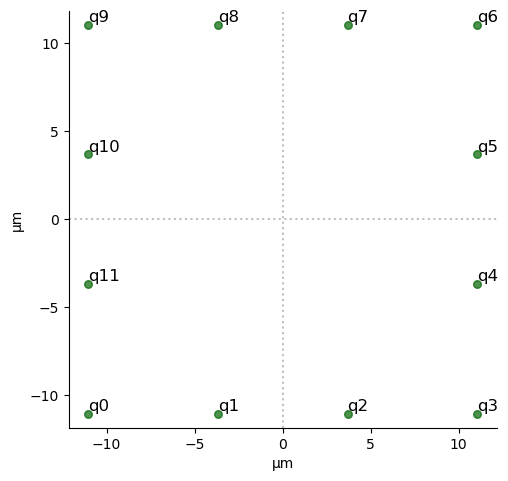

In [2]:
# Parameters in MHz and ns
U = 2 * np.pi * 5.0

Omega_max = 0.5 * U 

delta_0 = -1.0 * U 
delta_f = 1.0 * U 

R_interatomic = Chadoq2.rydberg_blockade_radius(U)
print(f'Interatomic Radius is: {R_interatomic}µm.')

N_side = 4
coords = [R_interatomic * np.r_[x,0] for x in range(N_side-1)] + [R_interatomic * np.r_[N_side-1,y] for y in range(N_side-1)] \
    + [R_interatomic * np.r_[N_side-1-x,N_side-1] for x in range(N_side-1)] + [R_interatomic * np.r_[0,N_side-1-y] for y in range(N_side-1)]
reg = Register.from_coordinates(coords, prefix='q')
N=len(reg._ids)

reg.draw()

In [32]:
# Duration of simulation (in ns)
T= 1500
time_domain=np.linspace(0, T, T)

A channel is declared on the Chadoq2 device in order to check the feasibility of the pulses. If the extreme values of $\Omega_{max}$, $\delta_0$ and $\delta_f$ exceed the thresholds proposed by Chadoq2, a restriction is required. The best case scenario is to take extreme values which coincide with those of the device, especially for $\delta_0$ and $\delta_f$ since they parameterise the adiabatic evolution of the system. 

In [4]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')

Omega_max=min([seq.declared_channels['ising'].max_amp, Omega_max])
delta_0=np.sign(delta_0)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_0)])
delta_f=np.sign(delta_f)*min([seq.declared_channels['ising'].max_abs_detuning, abs(delta_f)])
print(Omega_max/U,np.round(delta_0/U,2),delta_f/U)

0.5 -1.0 1.0


## Interpolated pulses
The parameters fed to the optimisation algorithm must uniquely define $\Omega$ and $\delta$. Interpolated pulses, once the interpolation method has been set, can be fully described by $2m$ parameters, which are $\{\Omega(t_i),\delta(t_i), i\in[1,m]\}$ with $t_i=T\times i/(m+1)$. The larger $m$ is, the more complex the pulse behaviour could be but also the more resources are needed since the parameters space is expanding. Here, the interpolation is done with monotonic cubic splines using `PchipInterpolator`. 

<img src="files/interpolated_pulses.png" alt="Interpolated pulses" style="width: 800px;"/>

We create a random instance of interpolated pulse using Pulser. 

In [5]:
# Size of the parameter space
m=3

# Random instance of the parameter space
para = np.r_[np.random.uniform(0,Omega_max,m),np.random.uniform(delta_0,delta_f,m)]

We define an interpolation function which takes as argument a set of parameters and returns the interpolated pulses associated. 

In [6]:
def interp_pulse_functions(Omega_pts,delta_pts,T):
    m=len(Omega_pts)
    ti=np.linspace(0,T,m)

    cso = PchipInterpolator(ti,np.array(Omega_pts))
    csd = PchipInterpolator(ti,np.array(delta_pts))
    def Omega(t,*args):
        return cso(t)
    def delta(t,*args):
        return csd(t)
    return Omega,delta

In [7]:
def create_interp_pulse(para):
    Omega_pts = np.r_[1e-9, para[:m], 1e-9]
    delta_pts = np.r_[delta_0, para[m:], delta_f]
    Omega_func, delta_func = interp_pulse_functions(Omega_pts, delta_pts,T)
    Omega,delta=np.array(Omega_func(time_domain)),np.array(delta_func(time_domain))
    P=Pulse(CustomWaveform(Omega),CustomWaveform(delta),0)
    return P

Using Pulser, we define a Sequence on the Chadoq2 device and add the pulse to it. We can also visualize it.  

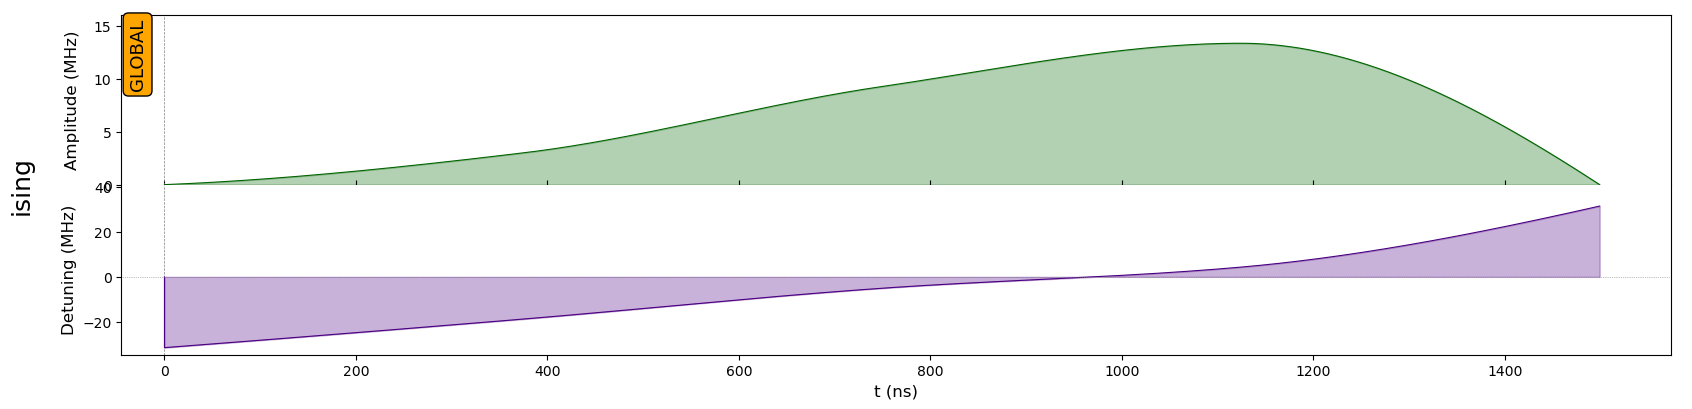

In [8]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
seq.add(create_interp_pulse(para),'ising')
seq.draw()

If we simulate the effect of the sequence on the system we obtain the final state. With each set of parameters, a state of the system can be obtained.  

In [9]:
simul = Simulation(seq)
results = simul.run()
final = results.states[-1]

Once the first optimised pulse shapes are obtained, it is worth adding constraints to the interpolated shapes such as strict growth or derivative limitation to further guide the optimisation.   

## Structural factor

In order for the optimisation algorithm to distinguish between these states and thus to browse the parameter space in search of an optimal shape of pulse, we need to assign a score to each set based on the state it allows us to reach. With the algorithm set to look for minimum, the AF state should have a score of 0 and all other states strictly positive score. The score will be defined based on the Néel structure factor $S_{Néel}$ defined in the tutorial _Preparing an AF state in the Ising model_ since we want an observable accessible by the processor. 

In [10]:
def occupation(j, N):
    up = qutip.basis(2,0)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = up * up.dag()
    return qutip.tensor(prod)

def get_corr_pairs(k, l, register, R_interatomic):
    corr_pairs = []
    for i, qi in enumerate(register.qubits):
        for j, qj in enumerate(register.qubits):
            r_ij = register.qubits[qi]-register.qubits[qj]
            distance = np.linalg.norm(r_ij - R_interatomic*np.array([k, l]))
            if distance < 1:
                corr_pairs.append([i, j])
    return corr_pairs

def get_corr_function(k, l, reg, R_interatomic, state):
    N_qubits = len(reg.qubits)
    corr_pairs = get_corr_pairs(k, l, reg, R_interatomic)
    if len(corr_pairs)==0:
        return 0
    else:
        operators = [occupation(j, N_qubits) for j in range(N_qubits)]
        covariance = 0
        for qi, qj in corr_pairs:
            covariance += qutip.expect(operators[qi]*operators[qj], state)
            covariance -= qutip.expect(operators[qi], state)*qutip.expect(operators[qj], state)
        return covariance/len(corr_pairs)   

def get_full_corr_function(reg, state):
    N= len(reg.qubits)
    reg2=Register.rectangle(1,N,spacing=R_interatomic)
    correlation_function = {}
    l=0
    for k in range(-N+1, N):
        correlation_function[(k, l)] = get_corr_function(k, l, reg2, R_interatomic, state)
    return correlation_function

def get_neel_structure_factor(reg, R_interatomic, state):
    N = len(reg.qubits)
    reg2=Register.rectangle(1,N,spacing=R_interatomic)
    st_fac = 0
    l=0
    for k in range(-N+1, N):
        kk = np.abs(k)
        if not k == 0:
            st_fac += 4 * (-1)**kk * get_corr_function(k, l, reg2, R_interatomic, state)
    return st_fac

We will use one of Pulser's methods (`sample_final_state()` which belongs to the `SimulationResults` class) to sample from a state, wrapped in a function that displays those bitstrings above a certain threshold `min_p`:

In [11]:
from pulser.simresults import SimulationResults

def proba_from_state(state, min_p=0.1):
    study = SimulationResults([state], dim=2, size=N, basis_name='ground-rydberg')
    sampling = study.sample_final_state(meas_basis='ground-rydberg', N_samples=1000)
    return {k: f'{100*v/study.N_samples}%' for k,v in sampling.items() if v/study.N_samples > min_p}

Let's try it out:

In [12]:
# Create antiferromagnetic state as the superposition of the two checkerboard patterns:
AF1 = qutip.tensor([qutip.basis(2,k%2) for k in range(N)])
AF2 = qutip.tensor([qutip.basis(2,(k+1)%2) for k in range(N)])
AF_state = (AF1 + AF2).unit()

proba_from_state(AF_state, min_p=0.3)

{'010101010101': '52.3%', '101010101010': '47.7%'}

$S_{Néel}$ should reach its maximum for the previously defined AF state. The obtained value will allow to normalise the score. 

In [83]:
t1=time.process_time()
print('S_Neel(AF state) =', get_neel_structure_factor(reg, R_interatomic, AF_state))
t2=time.process_time()
print('computed in', (t2-t1),'sec')

S_Neel(AF state) = 22.0
computed in 0.46875 sec


## Score function

The score function thus wraps the previous functions and assigns a positive score to each instance of parameters. 

In [14]:
def score(para):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(create_interp_pulse(para),'ising')
    
    simul = Simulation(seq, sampling_rate=0.1)
    results = simul.run()
    
    F = get_neel_structure_factor(reg, R_interatomic, results.states[-1])/(2*(N-1))
    return 1 - F

In [15]:
score(para)

0.682878160482691

# Optimisation
## Bayesian search 
Bayesian optimisation method has two keywords: model and decide. 

It consists of both a statistical model that simulates the unknown landscape function $F$ and a decision maker, the acquisition function $a$, which indicates where the next evaluation will be most likely to enhance optimization. Two distinct stages are carried out. In the supervised training, $F$ is surveyed according to an initial space-filling pattern. For small-sized spaces, the probing points $\{x_i\}$ can be formed into a discrete grid efficiently covering the entire search space. However, as the number of dimensions grows, it becomes less resource-consuming to conduct a uniformly random sample of $n$ points. 

A prior surrogate model of $F$ is established knowing only its values $\{F(x_i)\}_{1:n}$ at those $n$ points. Then, in the research part, each new point of a remaining budget $M-n$ is iteratively selected and used to update the model. That model provides a posterior probability distribution $f$, which approximates $F$ at every $x$. Using Gaussian processes for the modelling enables to get normally distributed $f(x)$, fully described by only two parameters: a mean and a variance.

At each step of the algorithm, once the landscape  has been approximated over the search space, the acquisition function $a(x)$ can be updated, being completely determined by the  current distribution $f(x)$. $a$ relates to how desirable evaluating $F$ at $x$ is expected to be and its straightforward construction makes it a relatively inexpensive function to evaluate and thus to optimise. By focusing alternatively on exploration and exploitation, $a$ helps to locate the next optimal point to query, $x^{*}$. It might seem that we just traded one optimization problem for another, but the call cost of $a$ is usually derisory compared to the black box one. $F(x^{*})$ is then added to the known values of $F$ in order to refine the next model. 

After $M$ calls to $F$, the Bayesian algorithm outputs $x_{opt}$, the most "useful" point for the experiment, i.e. the supposed global minimum of $F$ or the point with the smallest mean in case of strong noise for instance. 

<img src="files/diagram_baye_opt.png" alt="baye_opt" style="width: 700px;"/>

## Optimisation parameters
We are probing the parameter space cons a $2m$-dimensional hyper-rectangle $[0,\Omega_{max}]^m\times[\delta_0,\delta_f]^m$ with $n_r$ training points and a total of $n_c$ probing points. The optimisation is achieved using `gp_minimize` from the module `scikit-optimize`.

In [16]:
bounds = [(0.0, seq.declared_channels['ising'].max_amp)] * m + [(delta_0, delta_f)] * m

n_r = 40
n_c = 120

RESULT = gp_minimize(score, bounds, n_random_starts=n_r, n_calls=n_c, verbose=False,kappa=4.0)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7026
Function value obtained: 1.0035
Current minimum: 1.0035
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.7761
Function value obtained: 0.9334
Current minimum: 0.9334
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.6976
Function value obtained: 0.9982
Current minimum: 0.9334
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.9694
Function value obtained: 0.9895
Current minimum: 0.9334
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.9898
Function value obtained: 0.9802
Current minimum: 0.9334
Iteration No: 6 started. Evaluating

## Optimisation performance

To ensure that the optimisation is well-designed, i.e. enough but not too many steps, we plot its performance in terms of the minimum score found after $n_{calls}$ to the score function.

In [17]:
def sort_improv(RESULT):
    score_vals = RESULT.func_vals
    min = score_vals[0]
    score_list=[]
    for s in score_vals:
        if s<min:
            min=s
            score_list.append(min)
        else:
            score_list.append(min)
    return score_list

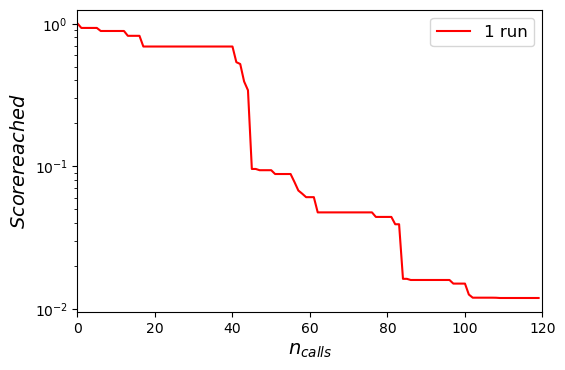

In [82]:
fig = plt.figure()
plt.semilogy(range(n_c), sort_improv(RESULT), 'r-')
plt.xlabel(r'$n_{calls}$', fontsize=14)
plt.ylabel(r'$Score reached$', fontsize=14)
plt.legend(['1 run'],fontsize=12)
plt.xlim(0,n_c)
plt.show()

Since Bayesian optimisation is a stochastic algorithm, its results may vary between different runs. A 5-run average convergence of the algorithm for the same parameters is shown below. The scores achieved after the total number of calls all remain within an appreciable range.

<img src="files/Average_convs.png" alt="AFgrid" style="width: 700px;"/>

## Optimised pulse
An interpolated pulse is produced based on the optimised parameters RESULT.x and then added to a new sequence.

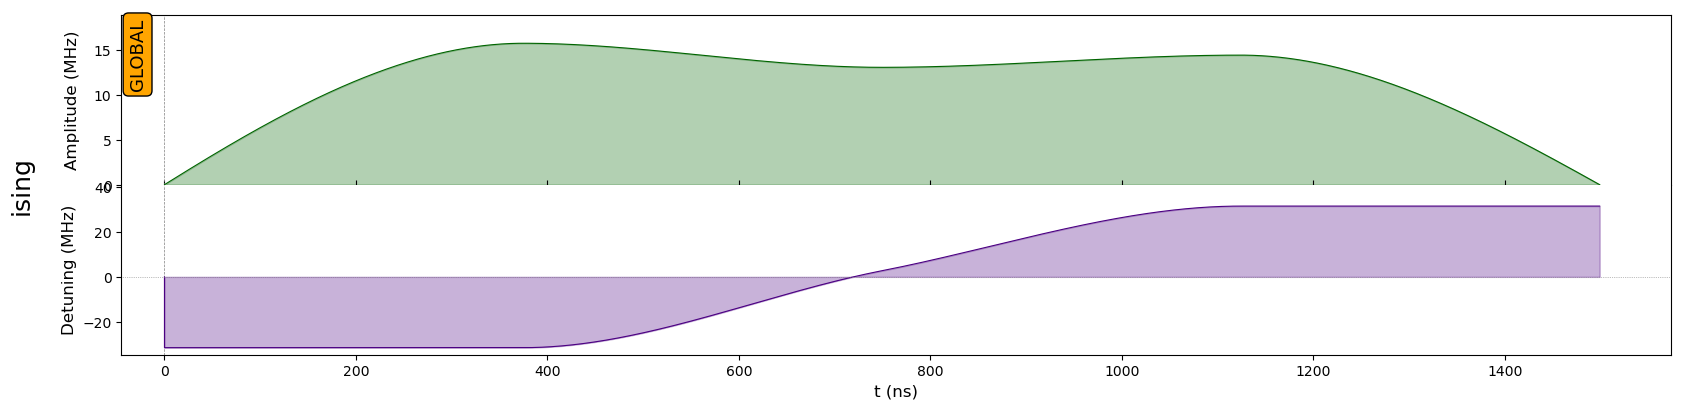

In [19]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')
P = create_interp_pulse(RESULT.x)
seq.add(P,'ising')
seq.draw()

The pulse sequence travels though the following path in the phase diagram of the system (the shaded area represents the antiferromagnetic phase):

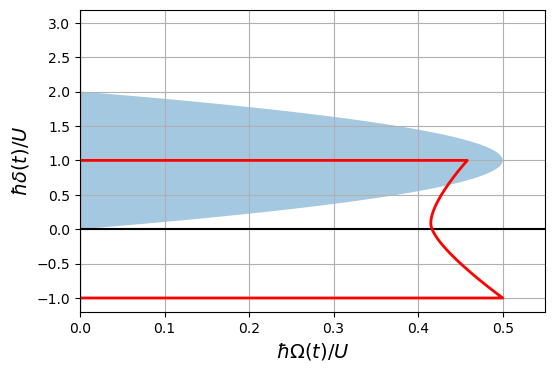

In [69]:
delta = []
omega = []
for x in seq._schedule['ising']:
    if isinstance(x.type,Pulse):
        omega += list(x.type.amplitude.samples / U)
        delta += list(x.type.detuning.samples / U)
        
fig, ax = plt.subplots()
ax.grid(True, which='both')

ax.set_ylabel(r"$\hbar\delta(t)/U$", fontsize=14)
ax.set_xlabel(r"$\hbar\Omega(t)/U$", fontsize=14)
ax.set_xlim(0, Omega_max/U*1.1)
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

y = np.arange(0.0, 3, 0.01)
x = 0.5 * (1 - 1.0 * (y - 1)**2)
ax.fill_between(x, y, alpha=0.4)

ax.plot(omega,delta, 'red', lw=2)
plt.show()

In [21]:
simul = Simulation(seq)
results = simul.run()
final=results.states[-1]
print('final =', proba_from_state(final, min_p=0.05))

s_neel = np.round(get_neel_structure_factor(reg, R_interatomic, final),3)
print(f'S_Neel (final) = {s_neel}')


final = {'010101010101': '48.4%', '101010101010': '49.0%'}
S_Neel (final) = 21.738


This value should be compared to its equivalent in the tutorial _Preparing an AF state in the Ising model_. For a ramp pulse with the same parameters and for a square configuration, the structural factor is around $2.75$ for a maximum of $24$. 

In [71]:
# Skip parameter. Only 1 out of 10 pts are kept to enhance the speed.
a = 10
time_domain_reduced = [a*i for i in range(len(results.states)//a)]
S_Neel_states=[get_neel_structure_factor(reg, R_interatomic, results.states[a*i]) for i in range(len(results.states)//a)]

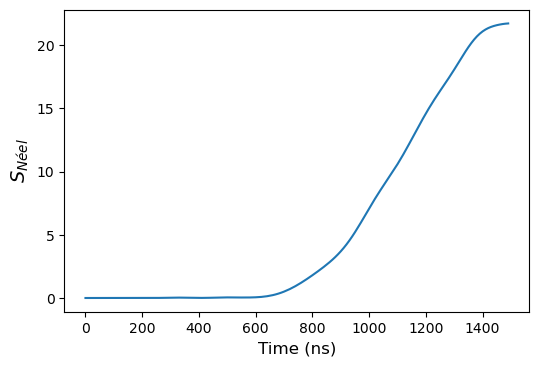

In [81]:
plt.figure()
plt.plot(time_domain_reduced,S_Neel_states)
plt.xlabel('Time (ns)',fontsize=12)
plt.ylabel(r'$S_{Néel}$',fontsize=14)

plt.show()

## Correlation properties
To identify any AF properties of the final state, it is also possible to examine its correlation function $g^{(2)}$. 

[[-0.24786824  0.24720161 -0.2466522   0.24663882 -0.24682752  0.2469159
  -0.2468146   0.24670329 -0.2466522   0.24706162 -0.24789425  0.24999977
  -0.24789425  0.24706162 -0.2466522   0.24670329 -0.2468146   0.2469159
  -0.24682752  0.24663882 -0.2466522   0.24720161 -0.24786824]]


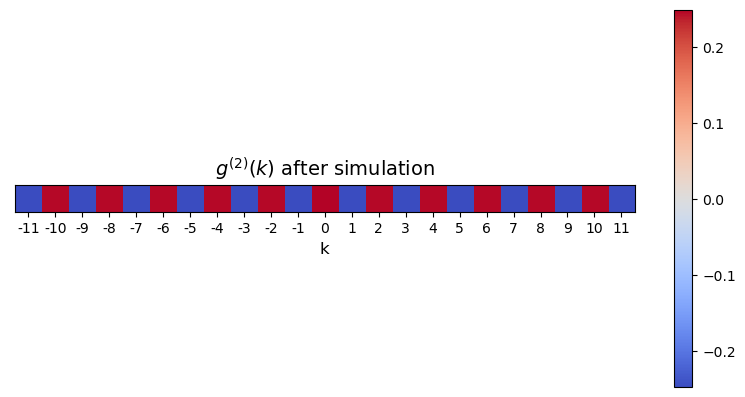

In [87]:
correlation_function = get_full_corr_function(reg, final)

A = np.reshape(list(correlation_function.values()), (1, 2*N-1))
print(A)

plt.figure(figsize=(10,5))
plt.imshow(A, cmap='coolwarm')
plt.xlabel('k',fontsize=12)
plt.xticks(range(A.shape[1]), ['{}'.format(i) for i in range(-N + 1, N)])
plt.title(r'$g^{(2)}(k)$ after simulation', fontsize=14)
plt.yticks([])
plt.colorbar()
plt.show()

Note that the correlation function would follow an exponential decay (modulo finite-size effects), which is best observed at larger system sizes. A perfect AF state should be as decorrelated as possible, i.e. with a correlation length as great as possible. 